# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [3]:
!wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip

--2025-05-15 05:48:42--  https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.118, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7439277 (7.1M) [application/zip]
Saving to: ‘SST-2.zip.1’

SST-2.zip.1         100%[===================>]   7.09M  41.3MB/s    in 0.2s    

2025-05-15 05:48:42 (41.3 MB/s) - ‘SST-2.zip.1’ saved [7439277/7439277]



In [4]:
!unzip /content/SST-2.zip

Archive:  /content/SST-2.zip
replace SST-2/dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SST-2/dev.tsv           
replace SST-2/original/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SST-2/original/README.txt  
replace SST-2/original/SOStr.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SST-2/original/SOStr.txt  
replace SST-2/original/STree.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SST-2/original/STree.txt  
replace SST-2/original/datasetSentences.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SST-2/original/datasetSentences.txt  
replace SST-2/original/datasetSplit.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SST-2/original/datasetSplit.txt  
replace SST-2/original/dictionary.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SST-2/original/dictionary.txt  
replace SST-2/original/original_rt_snippets.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SST-2/original/original_rt_snippets.

In [5]:
import pandas as pd

train_data_path = '/content/SST-2/train.tsv'
dev_data_path = '/content/SST-2/dev.tsv'

df_train = pd.read_csv(train_data_path, sep='\t')
df_dev = pd.read_csv(dev_data_path, sep='\t')

train_pos_counts = df_train.label.value_counts().get(1)
print('train positive: ', train_pos_counts)
train_neg_counts = df_train.label.value_counts().get(0)
print('train negative: ', train_neg_counts)

dev_pos_counts = df_dev.label.value_counts().get(1)
print('dev positive: ', dev_pos_counts)
dev_neg_counts = df_dev.label.value_counts().get(0)
print('dev negative: ', dev_neg_counts)

train positive:  37569
train negative:  29780
dev positive:  444
dev negative:  428


## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [6]:
from collections import Counter

def convert_text2feature(row):
    text = str(row.iloc[0])

    tokens = text.split(' ')

    return dict(Counter(tokens))

df_train['feature'] = df_train.apply(convert_text2feature, axis=1)
df_dev['feature'] = df_dev.apply(convert_text2feature, axis=1)

df_train.head(5)

,sentence,label,feature
0,hide new secretions from the parental units,0,"{'hide': 1, 'new': 1, 'secretions': 1, 'from':..."
1,"contains no wit , only labored gags",0,"{'contains': 1, 'no': 1, 'wit': 1, ',': 1, 'on..."
2,that loves its characters and communicates som...,1,"{'that': 1, 'loves': 1, 'its': 1, 'characters'..."
3,remains utterly satisfied to remain the same t...,0,"{'remains': 1, 'utterly': 1, 'satisfied': 1, '..."
4,on the worst revenge-of-the-nerds clichés the ...,0,"{'on': 1, 'the': 2, 'worst': 1, 'revenge-of-th..."


## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [5]:
import numpy as np

def np_log(x):
    return np.log(np.clip(a=x, a_min=1e-10, a_max=1e+10))

def sigmoid(x):
    return np.exp(np.minimum(0, x)) / (1 + np.exp(-np.abs(x)))

def cross_entropy_loss(y, t):
    return  - (t * np_log(y) + (1 - t) * np_log(1 - y)).mean()

class LogisticRegression():
    def __init__(self, in_dim, out_dim):
        self.W = np.random.uniform(low=-0.05, high=0.05, size=(in_dim, out_dim)).astype('float32')
        self.b = np.zeros(shape=(out_dim,)).astype('float32')

    def __call__(self, x):
        return sigmoid(np.matmul(x, self.W) + self.b)

    def compute_loss(self, y, t):
        return cross_entropy_loss(y, t)

    def update_parameter(self, x, delta, batch_size, eps):
        dW = np.matmul(x.T, delta) / batch_size
        db = np.matmul(np.ones(shape=(batch_size)), delta) / batch_size
        self.W -= eps * dW
        self.b -= eps * db

def train(model, x, t, eps=0.01):
    batch_size = x.shape[0]

    y = model(x)

    loss = model.compute_loss(y, t)

    delta = y - t

    model.update_parameter(x, delta, batch_size, eps)

    threshold = 0.5
    pred_labels = (y > threshold).astype(int)

    true_labels = t

    accuracy = np.mean(pred_labels == true_labels)

    return loss, accuracy

def valid(model, x, t):
    y = model(x)
    loss = model.compute_loss(y, t)

    threshold = 0.5
    pred_labels = (y > threshold).astype(int)

    true_labels = t

    accuracy = np.mean(pred_labels == true_labels)

    return loss, y, accuracy


In [7]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=True)

X_train = vectorizer.fit_transform(df_train['feature'])
X_dev = vectorizer.transform(df_dev['feature'])

X_train = X_train.toarray()
X_dev = X_dev.toarray()
print(X_train.shape)
print(X_dev.shape)

(67349, 14817)
(872, 14817)


In [8]:
def extract_labels(df):
    return df['label'].astype(int).values.reshape(-1, 1)

t_train = extract_labels(df_train)
t_dev = extract_labels(df_dev)

print(t_train.shape)
print(t_dev.shape)

(67349, 1)
(872, 1)


In [16]:
epoch = 2000


model = LogisticRegression(in_dim=X_train.shape[1], out_dim=t_train.shape[1])

for i in range(1, epoch+1):
    train_loss, train_accuracy = train(model, X_train, t_train, eps=0.1)

    valid_loss, y, valid_accuracy = valid(model, X_dev, t_dev)

    if i % 10 == 0:
        print(f'epoch: {i} train accuracy: {train_accuracy:.8f} valid accuracy: {valid_accuracy:.8f}')



epoch: 10 train accuracy: 0.55861260 valid accuracy: 0.50229358
epoch: 20 train accuracy: 0.56263642 valid accuracy: 0.51261468
epoch: 30 train accuracy: 0.56217613 valid accuracy: 0.51376147
epoch: 40 train accuracy: 0.56216128 valid accuracy: 0.51490826
epoch: 50 train accuracy: 0.56336397 valid accuracy: 0.51834862
epoch: 60 train accuracy: 0.56475968 valid accuracy: 0.52064220
epoch: 70 train accuracy: 0.56646721 valid accuracy: 0.52522936
epoch: 80 train accuracy: 0.56948136 valid accuracy: 0.53211009
epoch: 90 train accuracy: 0.57320821 valid accuracy: 0.53440367
epoch: 100 train accuracy: 0.57610358 valid accuracy: 0.54013761
epoch: 110 train accuracy: 0.57870199 valid accuracy: 0.55045872
epoch: 120 train accuracy: 0.58101828 valid accuracy: 0.55275229
epoch: 130 train accuracy: 0.58401758 valid accuracy: 0.56192661
epoch: 140 train accuracy: 0.58674962 valid accuracy: 0.56536697
epoch: 150 train accuracy: 0.58918469 valid accuracy: 0.57110092
epoch: 160 train accuracy: 0.59130

## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [17]:
y = model(X_dev[0])
threshold = 0.5
pred_label = (y > threshold).astype(int).item()

true_label = t_dev[0].item()

print(f'predict: {pred_label} true: {true_label}')

predict: 1 true: 1


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [18]:
print(f'P(pos|pos) = {y.item()}, P(neg|pos) = {1-y.item()}')

P(pos|pos) = 0.7017520210769926, P(neg|pos) = 0.29824797892300736


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [19]:
text = 'the worst movie I \'ve ever seen'

tokens = text.split(' ')

feature = dict(Counter(tokens))

X = vectorizer.transform(feature)

X = X.toarray()

y = model(X)
threshold = 0.5
pred_label = (y > threshold).astype(int).item()

print('pred label:', pred_label)

pred label: 0


## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

In [30]:
from sklearn.metrics import confusion_matrix

y_dev = model(X_dev)

pred_label_dev = (y_dev > threshold).astype(int)

cm = confusion_matrix(t_dev, pred_label_dev)
print(cm)

[[273 155]
 [ 88 356]]


## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_train = model(X_train)

pred_label_train = (y_train > threshold).astype(int)
print('train')
accuracy = accuracy_score(t_train, pred_label_train)
precision = precision_score(t_train, pred_label_train)
recall = recall_score(t_train, pred_label_train)
f1 = f1_score(t_train, pred_label_train)
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')

print('valid')
accuracy = accuracy_score(t_dev, pred_label_dev)
precision = precision_score(t_dev, pred_label_dev)
recall = recall_score(t_dev, pred_label_dev)
f1 = f1_score(t_dev, pred_label_dev)
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1}')

train
accuracy: 0.6960459695021456 precision: 0.6669009410019132 recall: 0.9092602943916527 f1: 0.7694473538984807
valid
accuracy: 0.7213302752293578 precision: 0.6966731898238747 recall: 0.8018018018018018 f1: 0.7455497382198953


## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [48]:
W_flat = model.W.flatten()
sorted_indices = np.argsort(W_flat)
feature_names = vectorizer.get_feature_names_out()

n = 20
print('Worst20')
for i in sorted_indices[:20]:
    feature_name = feature_names[i]
    weight = W_flat[i]
    print(f"feature name: {feature_name:>15}, weight: {weight:.4f}")

print('Best20')
for i in sorted_indices[-20:]:
    feature_name = feature_names[i]
    weight = W_flat[i]
    print(f"feature name: {feature_name:>15}, weight: {weight:.4f}")

Worst20
feature name:             too, weight: -0.8674
feature name:             bad, weight: -0.8025
feature name:             n't, weight: -0.7713
feature name:              no, weight: -0.6946
feature name:              or, weight: -0.5562
feature name:            like, weight: -0.4722
feature name:             not, weight: -0.4402
feature name:            plot, weight: -0.4215
feature name:            just, weight: -0.3573
feature name:           worst, weight: -0.3505
feature name:         nothing, weight: -0.3495
feature name:            dull, weight: -0.3391
feature name:         minutes, weight: -0.3333
feature name:        dialogue, weight: -0.3116
feature name:            flat, weight: -0.2983
feature name:            been, weight: -0.2920
feature name:             out, weight: -0.2685
feature name:              by, weight: -0.2684
feature name:              so, weight: -0.2581
feature name:           would, weight: -0.2563
Best20
feature name:        powerful, weight: 0.2477

## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

In [15]:
from sklearn import linear_model

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

accuracy_scores = []

t_train = t_train.ravel()
t_dev = t_dev.ravel()

for C in C_values:
    model = linear_model.LogisticRegression(C=C, solver='liblinear', random_state=42, max_iter=1000)
    model.fit(X_train, t_train)

    accuracy = model.score(X_dev, t_dev)
    accuracy_scores.append(accuracy)


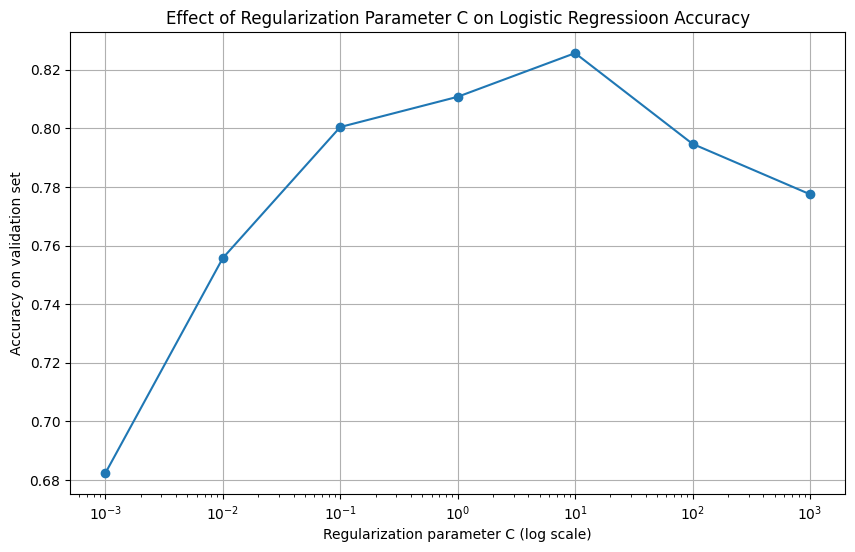

In [10]:
import matplotlib.pyplot as plt
# Cはラムダの逆数
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracy_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization parameter C (log scale)')
plt.ylabel('Accuracy on validation set')
plt.title('Effect of Regularization Parameter C on Logistic Regressioon Accuracy')
plt.grid(True)
plt.show()